In [1]:
import matplotlib.pyplot as plt
import torch
import pytorch3d
import numpy as np

from ray_sampling import RaySampler
from point_sampling import sample_along_camera_ray

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [3]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [4]:
dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

dataset_set : train, dataset : CO3D Dataset #frames=81, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : val, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : test, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]


In [5]:
data_frame = next(iter(test_loader))

print(data_frame.image_rgb.shape)

torch.Size([10, 3, 800, 800])


In [6]:
camera = data_frame.camera

H, W = (800, 800)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


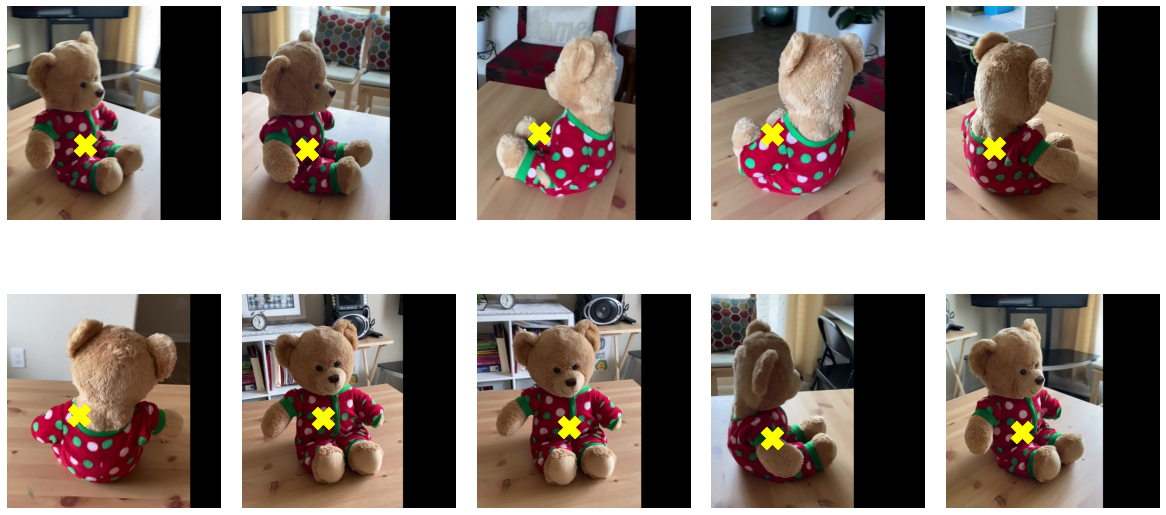

In [7]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)

# ndc coord --> screen coord
ndc2screen = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(camera, 
                                                                    image_size=(H, W), with_xyflip=True).cpu()
imgs = data_frame.image_rgb.cpu()

for i, img in enumerate(imgs):
    plt.subplot(2, 5, i + 1)
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)

    principal_ndc = camera.principal_point[i]

    principal_with_z = torch.ones((1, 3))
    principal_with_z[..., :2] = principal_ndc

    principal_screen = ndc2screen.transform_points(principal_with_z)[i]

    plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), marker='X', c='yellow', s=500)
    
    plt.axis("off")

In [13]:
target_cam_idx, src1_cam_idx, src2_cam_idx, src3_cam_idx, src4_cam_idx = 0, 1, 6, 8, 9
print(f"target camera index : {target_cam_idx}")
print(f"source camera index : {src1_cam_idx, src2_cam_idx, src3_cam_idx, src4_cam_idx}")

data = {}
data["rgb"] = data_frame.image_rgb[target_cam_idx]
data["rgb_path"] = data_frame.image_path[target_cam_idx]
data["mask"] = data_frame.fg_probability[target_cam_idx]
data["camera"] = data_frame.camera
target_camera_position = data_frame.camera.get_camera_center()[target_cam_idx]
near = torch.norm(target_camera_position) - 8
far = torch.norm(target_camera_position) + 8
depth_range =  torch.tensor([near, far], dtype=torch.float32)
data["depth_range"] = depth_range

device = "cpu"

target camera index : 0
source camera index : (1, 6, 8, 9)


In [14]:
ray_sampler = RaySampler(data, target_cam_idx, device, resize_factor=1, render_stride=1)

In [15]:
rays_d = ray_sampler.rays_d
print(rays_d.shape)
print(rays_d[0])
print(rays_d[W-1])
print(rays_d[W*(H-1)])
print(rays_d[W*H-1])

world_bound_ray = [rays_d[0], rays_d[W-1], rays_d[W*(H-1)], rays_d[W*H-1]]

rays_o = ray_sampler.rays_o
print(rays_o.shape)
print(rays_o[0])
print(rays_o[W-1])
print(rays_o[W*(H-1)])
print(rays_o[W*H-1])

camera_position = camera.get_camera_center()[target_cam_idx]
print('\n', camera_position)

torch.Size([640000, 3])
tensor([ 0.3915, -0.3660,  1.0010])
tensor([ 0.9930, -0.2053,  0.6333])
tensor([0.2001, 0.3312, 0.9926])
tensor([0.8016, 0.4919, 0.6249])
torch.Size([640000, 3])
tensor([-4.7442, -0.1732, -8.2143])
tensor([-4.7442, -0.1732, -8.2143])
tensor([-4.7442, -0.1732, -8.2143])
tensor([-4.7442, -0.1732, -8.2143])

 tensor([-4.7442, -0.1732, -8.2143])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_15520/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


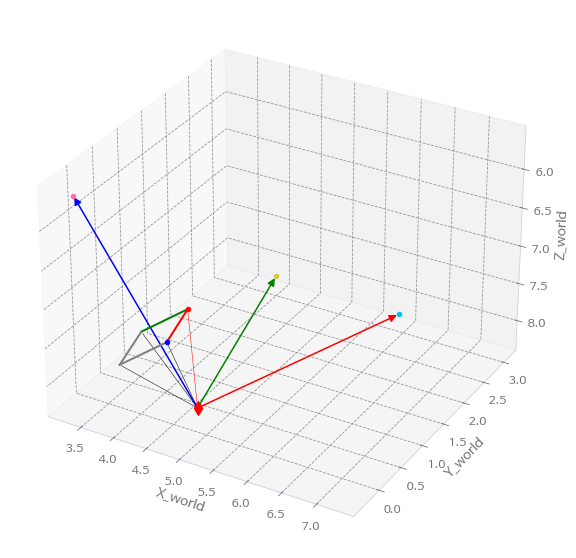

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera.get_camera_center()[target_cam_idx].numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)

left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')


R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

In [17]:
ray_batch = ray_sampler.random_sample(10, "center")

sampling_ray_d = ray_batch["ray_d"]
sampling_ray_o = ray_batch["ray_o"]

In [18]:
print(sampling_ray_d.shape)
print(sampling_ray_o.shape)

torch.Size([10, 3])
torch.Size([10, 3])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_15520/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


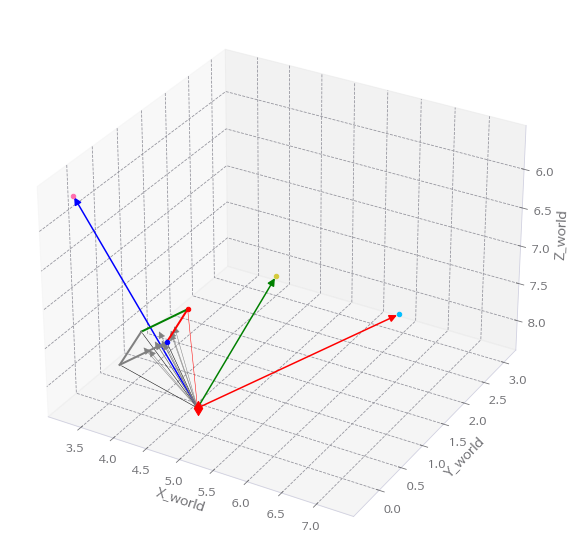

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera.get_camera_center()[target_cam_idx].cpu().numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)


R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])


for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)



for i, ray_d in enumerate(sampling_ray_d):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)


left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')




In [20]:
print(depth_range)

tensor([ 1.4875, 17.4875])


In [21]:
pts, z_vals = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                            30,
                            inv_uniform=False,
                            det=True)

In [ ]:
z_vals

/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_15520/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


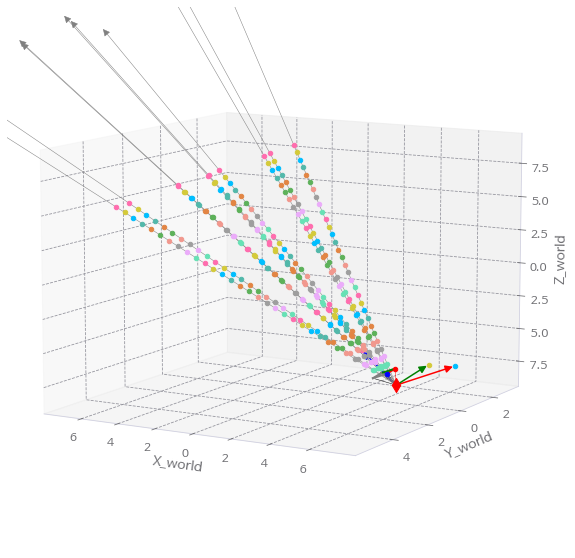

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=10, azim=120)

x, y, z = camera_position.numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)


for i, ray_d in enumerate(sampling_ray_d):
    xs = [x, x+ray_d[0].item()*30]
    ys = [y, y+ray_d[1].item()*30]
    zs = [z, z+ray_d[2].item()*30]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)
    

for i, pts_per_ray in enumerate(pts):
    for p in pts_per_ray:
        x, y, z = p.cpu()
        ax.scatter3D(p[0].item(), p[1].item(), p[2].item(), cmap="blue")
    


left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')


In [29]:
src_idxs = [src1_cam_idx, src2_cam_idx, src3_cam_idx, src4_cam_idx]
img_size = (800, 800)

In [36]:
proj_points = camera.transform_points_screen(pts.reshape(-1, 3), image_size=img_size)
print(proj_points.shape)

src_proj_points = proj_points[src_idxs]   # (N_src, N_rays*N_samples, 3)
print(src_proj_points.shape)

torch.Size([10, 300, 3])
torch.Size([4, 300, 3])


In [39]:
screen_to_ndc_transforms = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(camera, image_size=img_size, with_xyflip=True)[src_idxs]
src_proj_points_ndc = screen_to_ndc_transforms.transform_points(src_proj_points)
print(src_proj_points_ndc.shape)

src_grid = src_proj_points_ndc.reshape(-1, 10, 30, 3)[..., :2]   # (N_src, N_rays, N_samples, 2)
print(src_grid.shape)



src_proj_points = src_proj_points.reshape(-1, 10, 30, 3)
print(src_proj_points.shape)

torch.Size([4, 300, 3])
torch.Size([4, 10, 30, 2])
torch.Size([4, 10, 30, 3])


In [37]:
tgt_proj_points = proj_points[target_cam_idx]

print(tgt_proj_points.shape)

tgt_proj_points = tgt_proj_points.reshape(10, 30, 3)

print(tgt_proj_points.shape)

torch.Size([300, 3])
torch.Size([10, 30, 3])


In [27]:
principal_point = (400 - 400*camera.principal_point).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


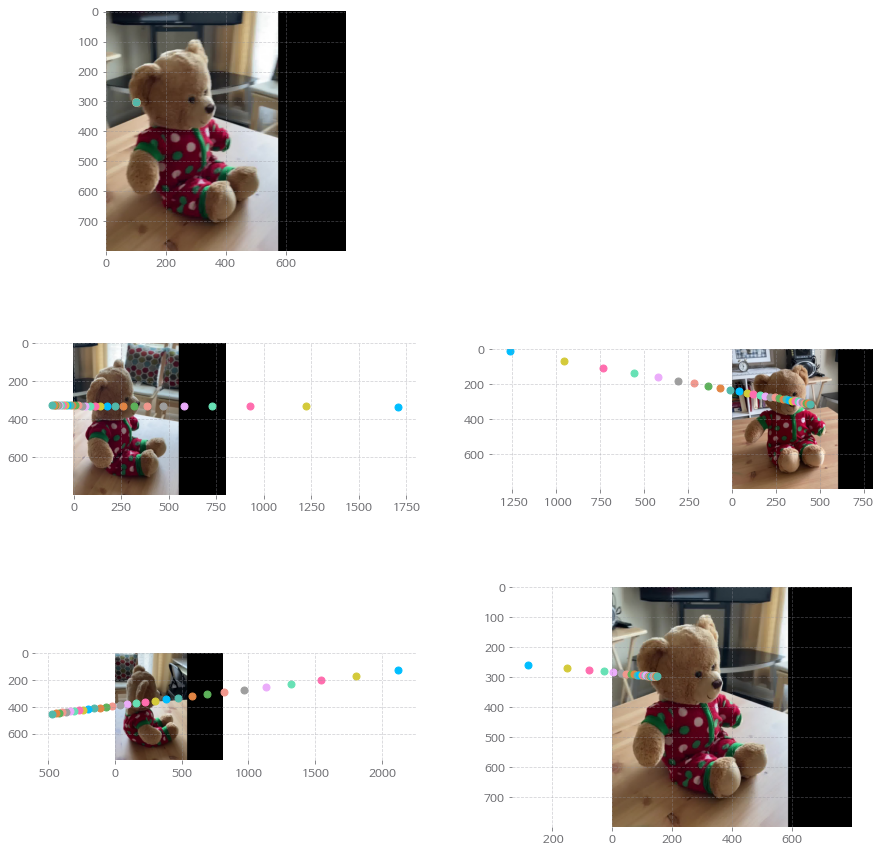

In [40]:
ray_idx = 9


plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)

img = data_frame.image_rgb[target_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[target_cam_idx, 0].item(), principal_point[target_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in tgt_proj_points[ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 3)

img = data_frame.image_rgb[src1_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src1_cam_idx, 0].item(), principal_point[src1_cam_idx, 1].item(), marker='X', c='yellow', s=300)
for point in src_proj_points[0, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 4)

img = data_frame.image_rgb[src2_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_proj_points[1, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 5)

img = data_frame.image_rgb[src3_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_proj_points[2, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 6)

img = data_frame.image_rgb[src4_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_proj_points[3, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)

In [48]:
src_grid_test = src_grid * (-400) + 400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


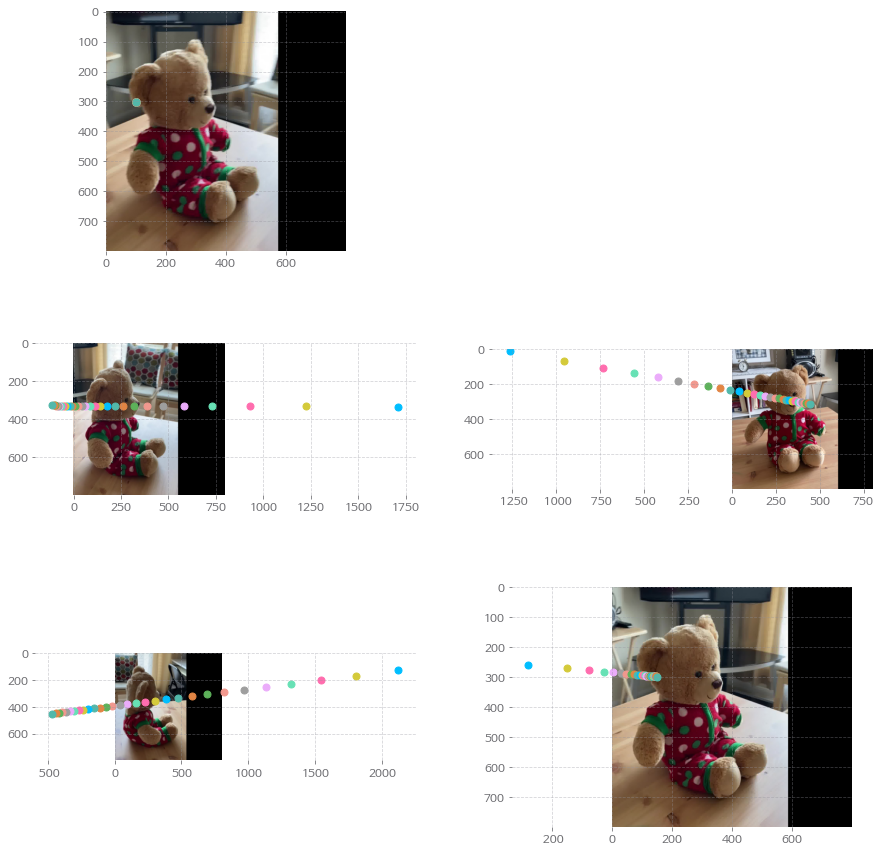

In [49]:
ray_idx = 9


plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)

img = data_frame.image_rgb[target_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[target_cam_idx, 0].item(), principal_point[target_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in tgt_proj_points[ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 3)

img = data_frame.image_rgb[src1_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src1_cam_idx, 0].item(), principal_point[src1_cam_idx, 1].item(), marker='X', c='yellow', s=300)
for point in src_grid_test[0, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 4)

img = data_frame.image_rgb[src2_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_grid_test[1, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 5)

img = data_frame.image_rgb[src3_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_grid_test[2, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(3, 2, 6)

img = data_frame.image_rgb[src4_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
# plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src_grid_test[3, ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)

In [22]:
tmp = torch.tensor([[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]],
                    [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]],
                    [[6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8]],
                    [[9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11]],
                    [[12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14]],
                    [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]],
                    [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]],
                    [[6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8]],
                    [[9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11]],
                    [[12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14]]])

print(tmp.shape)

torch.Size([10, 5, 3])


In [23]:
tmp_1 = tmp.reshape(-1, 3)
tmp_2 = tmp_1.reshape(10, 5, 3)
tmp_2 == tmp

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
  

In [19]:
from network.feature_network import FeatureNet
from network.model import NerFormer
import torch.nn.functional as F

In [20]:
device = "cuda"

In [21]:
feature_net = FeatureNet()
feature_net.to(device)

FeatureNet(
  (feature_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [22]:
batch_img = torch.stack([data_frame.image_rgb[src1_cam_idx], data_frame.image_rgb[src2_cam_idx], data_frame.image_rgb[src3_cam_idx], data_frame.image_rgb[src4_cam_idx]], dim=0).to(device)

print(batch_img.shape)

torch.Size([4, 3, 800, 800])


In [23]:
batch_img_features = feature_net(batch_img)
print(batch_img_features.shape)

torch.Size([4, 99, 800, 800])


In [24]:
screen_to_ndc = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(camera, image_size=(H, W), with_xyflip=True).to(device)

src1_screen_to_ndc = screen_to_ndc[src1_cam_idx]
src2_screen_to_ndc = screen_to_ndc[src2_cam_idx]
src3_screen_to_ndc = screen_to_ndc[src3_cam_idx]
src4_screen_to_ndc = screen_to_ndc[src4_cam_idx]

In [25]:
src1_proj_ndc = src1_screen_to_ndc.transform_points(src_proj_points[0])
src2_proj_ndc = src2_screen_to_ndc.transform_points(src_proj_points[1])
src3_proj_ndc = src3_screen_to_ndc.transform_points(src_proj_points[2])
src4_proj_ndc = src3_screen_to_ndc.transform_points(src_proj_points[3])

print(src1_proj_ndc.shape)

batch_proj_ndc = torch.stack([src1_proj_ndc, src2_proj_ndc, src3_proj_ndc, src4_proj_ndc], dim=0)[..., :2]
print(batch_proj_ndc.shape)

torch.Size([10, 30, 3])
torch.Size([4, 10, 30, 2])


In [26]:
batch_sampling_features = F.grid_sample(batch_img_features, batch_proj_ndc, align_corners=False, padding_mode="zeros", mode='bilinear')

print(batch_sampling_features.shape)

torch.Size([4, 99, 10, 30])


In [27]:
# (N_src, D_z, N_rays, N_s) >>>> (N_rays, N_s, N_src, D_z)
batch_sampling_features = batch_sampling_features.permute(2, 3, 0, 1)

print(batch_sampling_features.shape)

torch.Size([10, 30, 4, 99])


In [35]:
ray, sample = (ray_idx, 5)


print(f"index (ndx_x, ndx_y) = {src1_grid_idx[0, ray, sample]}\n")
print(src1_sampling_features[0, ray, sample])

index (ndx_x, ndx_y) = tensor([0.3171, 0.9450], device='cuda:0')

tensor([-0.0749,  0.3568,  0.0961, -0.0318,  0.0317, -0.1837, -0.0882,  0.2913,
        -0.0136, -0.3009, -0.0648,  0.1244, -0.2572,  0.4209,  0.1295, -0.1743,
         0.1545,  0.1069,  0.0705, -0.0836, -0.1146, -0.2328,  0.1371, -0.0451,
        -0.0256,  0.1294, -0.2058,  0.1958,  0.1728, -0.1939,  0.1185,  0.1157,
        -0.0904,  0.1552, -0.3498, -0.1610, -0.2556,  0.1910, -0.1131, -0.1560,
        -0.0587, -0.1477, -0.1343,  0.1926,  0.2240, -0.1419, -0.1566,  0.1814,
         0.1644, -0.2914, -0.0190,  0.2136,  0.2142,  0.1582,  0.1612,  0.1882,
         0.0024, -0.1167,  0.1545,  0.0808,  0.1400,  0.1013,  0.3156,  0.0891,
         0.0533,  0.0828, -0.2930, -0.1509, -0.1601,  0.0339,  0.1207,  0.0133,
        -0.0400, -0.0024, -0.0518,  0.0950,  0.2480,  0.1758,  0.0347,  0.1743,
         0.1532,  0.3364,  0.1165, -0.0876, -0.2928,  0.3402,  0.0760,  0.3537,
        -0.2875,  0.1659, -0.0885, -0.1924,  0.1522, -

In [36]:
print(400 - (-0.9166 * 400))
print(400 - (0.7863 * 400))

766.64
85.48000000000002


In [37]:
x = src1_proj_points[ray, sample][0].item()
y = src1_proj_points[ray, sample][1].item()
print(f"index (x, y) = {x} = {int(x)}, {y} = {int(y)}\n")

print(src1_feature_map[0, :, int(x), int(y)])

index (x, y) = 272.80523681640625 = 272, 21.9718017578125 = 21

tensor([-0.0800,  0.3378,  0.1186,  0.0042,  0.0415, -0.1553, -0.0971,  0.2346,
        -0.0245, -0.2660, -0.0447,  0.1660, -0.2787,  0.4256,  0.1359, -0.1424,
         0.1835,  0.1237,  0.0728, -0.0875, -0.1395, -0.2339,  0.1235, -0.0299,
        -0.0365,  0.1362, -0.2514,  0.1958,  0.1710, -0.1846,  0.1386,  0.1431,
        -0.0914,  0.1681, -0.2764, -0.1302, -0.1847,  0.1700, -0.1358, -0.2785,
        -0.1098, -0.1381, -0.1816,  0.1778,  0.0481, -0.0724, -0.2048,  0.1862,
         0.1343, -0.2080,  0.1317,  0.2203,  0.2457,  0.1085,  0.2139,  0.1423,
        -0.1672, -0.2185,  0.1869,  0.1810,  0.0963,  0.2562,  0.2139, -0.0411,
        -0.0238, -0.1664,  0.0491, -0.0735, -0.1257, -0.2417,  0.2707, -0.1846,
        -0.1261, -0.0221,  0.0305, -0.0821,  0.4923,  0.1886, -0.1046,  0.1757,
         0.2467,  0.1726,  0.2032, -0.0318,  0.0581,  0.0911,  0.0783,  0.0997,
        -0.3595,  0.0986, -0.1972, -0.2089, -0.0338, -0.

In [28]:
net = NerFormer(d_z=99)

In [29]:
net.to(device)

NerFormer(
  (linear_1): Linear(in_features=99, out_features=80, bias=False)
  (TE_1): Sequential(
    (0): TransformerEncoder(
      (multi_head_att): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=80, out_features=80, bias=True)
      )
      (Q_weights): Linear(in_features=80, out_features=80, bias=True)
      (K_weights): Linear(in_features=80, out_features=80, bias=True)
      (V_weights): Linear(in_features=80, out_features=80, bias=True)
      (dropout_1): Dropout(p=0.1, inplace=False)
      (dropout_2): Dropout(p=0.1, inplace=False)
      (layer_norm_1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (two_layer_MLP): Sequential(
        (0): Linear(in_features=80, out_features=80, bias=True)
        (1): ReLU()
        (2): Linear(in_features=80, out_features=80, bias=True)
      )
    )
    (1): TransformerEncoder(
      (multi_head_att): MultiheadAttention(
        (out

In [30]:
output = net(batch_sampling_features)

In [31]:
output[0].shape

torch.Size([10, 30, 1])

In [32]:
output[1].shape

torch.Size([10, 30, 3])